In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import pandas as pd
import numpy as np

#Data preprocessing library
import imblearn                   
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


from tqdm import tqdm

#Data Visualization library
import matplotlib.pyplot as plt   
import seaborn as sns

In [136]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Hackathon AnnalyticsVidya/train_s3TEQDk.csv')
data.head(10)

In [138]:
data.shape

(245725, 11)

In [144]:
real_data.dtypes

Gender                 object
Age                     int64
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

In [139]:
data.isna().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [141]:
data['Credit_Product'].value_counts()

No     144357
Yes     72043
Name: Credit_Product, dtype: int64

In [142]:
data.nunique()

ID                     245725
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    135292
Is_Active                   2
Is_Lead                     2
dtype: int64

In [143]:
real_data = data.drop(['ID','Region_Code'],axis=1)

In [145]:
real_data['Is_Lead'].value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

In [146]:
real_data['Is_Active'].value_counts()

No     150290
Yes     95435
Name: Is_Active, dtype: int64

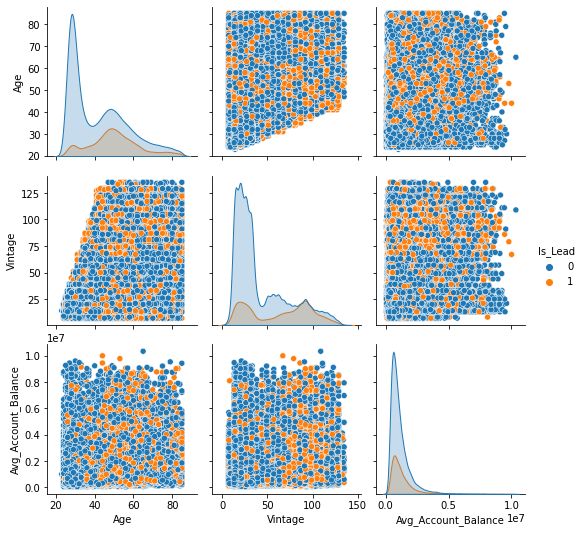

In [147]:
sns.pairplot(real_data, hue='Is_Lead' , diag_kind = 'kde' )

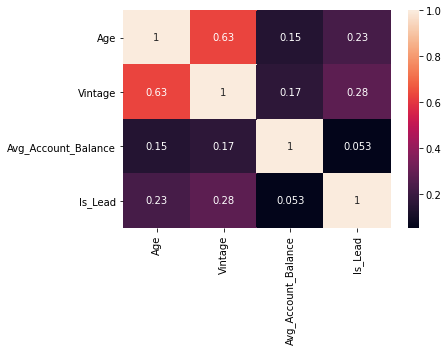

In [197]:
sns.heatmap(real_data.corr(), annot = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

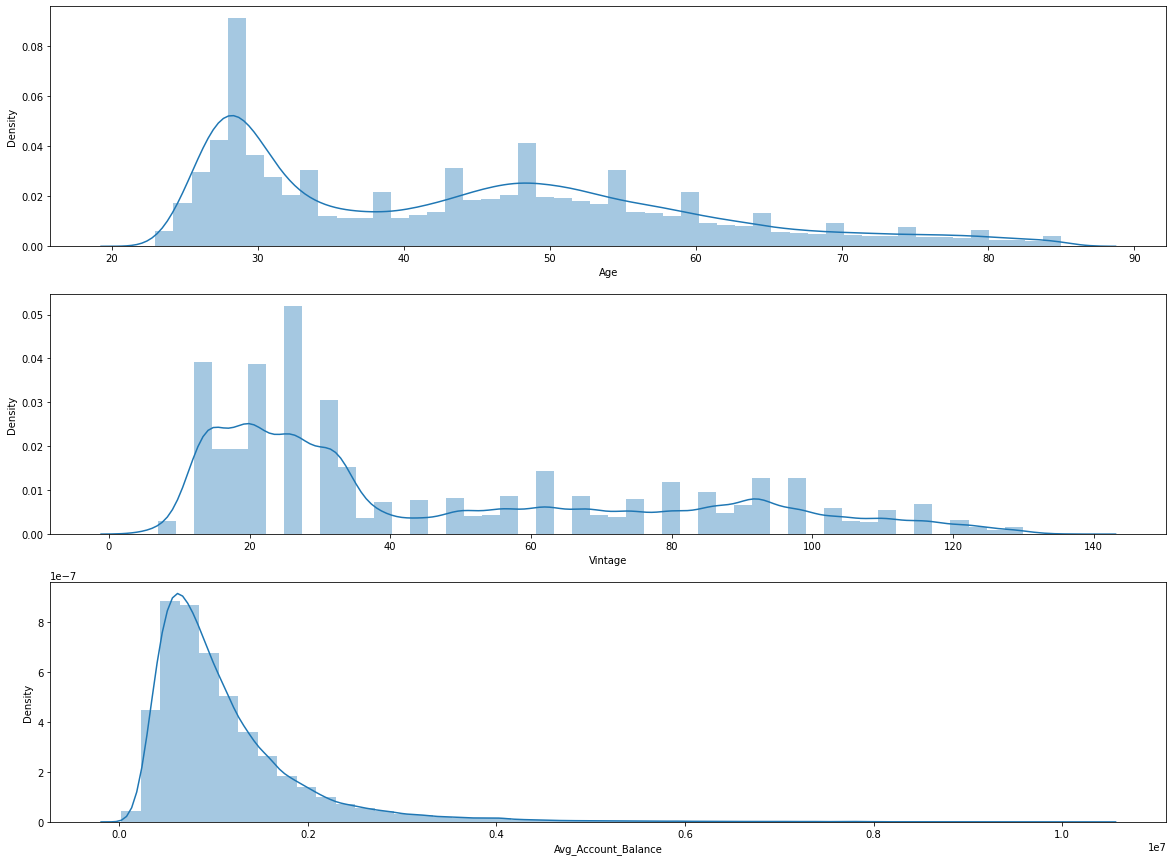

In [148]:
cols = real_data.columns[real_data.dtypes == 'int64'][:3]
plt.figure(figsize=(20, 15))
for i in range(len(cols)):
  plt.subplot(3, 1, i+1)
  sns.distplot(real_data[cols[i]])

In [159]:
X = real_data.iloc[:,:8]
y = real_data.iloc[:,-1]

In [160]:
X

,Gender,Age,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Female,73,Other,X3,43,No,1045696,No
1,Female,30,Salaried,X1,32,No,581988,No
2,Female,56,Self_Employed,X3,26,No,1484315,Yes
3,Male,34,Salaried,X1,19,No,470454,No
4,Female,30,Salaried,X1,33,No,886787,No
...,...,...,...,...,...,...,...,...
245720,Male,51,Self_Employed,X3,109,NaN,1925586,No
245721,Male,27,Salaried,X1,15,No,862952,Yes
245722,Female,26,Salaried,X1,13,No,670659,No
245723,Female,28,Salaried,X1,31,No,407504,No


In [161]:
X = pd.get_dummies(data=X, columns=['Gender','Occupation','Channel_Code','Is_Active'], drop_first = True)

In [162]:
for j,i in tqdm(enumerate(X['Credit_Product'])):
  if i == 'Yes':
    X['Credit_Product'][j] = 1
  elif i == 'No':
    X['Credit_Product'][j] = 0

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
245725it [02:23, 1706.60it/s]


In [164]:
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)

In [165]:
Xtrans[:,2] = [1 if i >= 0.5 else 0 for i in Xtrans[:,2]]

In [166]:
X.columns

Index(['Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance',
       'Gender_Male', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Channel_Code_X2', 'Channel_Code_X3',
       'Channel_Code_X4', 'Is_Active_Yes'],
      dtype='object')

In [167]:
Xtrans = pd.DataFrame(Xtrans)
Xtrans.columns =['Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance',
       'Gender_Male', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Channel_Code_X2', 'Channel_Code_X3',
       'Channel_Code_X4', 'Is_Active_Yes']

In [169]:
#upsampling the train dataset usimg SMOTE

print("Before UpSampling, counts of label '1': {}".format(sum(y==1)))
print("Before UpSampling, counts of label '0': {} \n".format(sum(y==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_upsampled, y_usampled = sm.fit_sample(Xtrans, y.ravel())


print("After UpSampling, counts of label '1': {}".format(sum(y==1)))
print("After UpSampling, counts of label '0': {} \n".format(sum(y==0)))



print('After UpSampling, the shape of train_X: {}'.format(X_upsampled.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y.shape))

Before UpSampling, counts of label '1': 58288
Before UpSampling, counts of label '0': 187437 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After UpSampling, counts of label '1': 58288
After UpSampling, counts of label '0': 187437 

After UpSampling, the shape of train_X: (374874, 12)
After UpSampling, the shape of train_y: (245725,) 



In [170]:
# Split the data into train and test sets

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_upsampled, y_usampled, test_size=0.2,
                                                                    stratify=y_usampled, random_state=42)

In [171]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'max_depth': [3,5,7,9],  
#               'min_samples_leaf': [3,5,7,9], 
#               'n_estimators':[100,150,200,250]}  
   
# grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# # fitting the model for grid search 
# grid.fit(X_train, y_train) 
 
# # print best parameter after tuning 
# print(grid.best_params_) 
# grid_predictions = grid.predict(X_test)

In [172]:
rf = RandomForestClassifier(n_jobs=-1,criterion = 'entropy',n_estimators = 150, max_depth = 9, min_samples_leaf=3, random_state=42)
rf.fit(X_train, y_train)

print("Train accuracy",rf.score(X_train, y_train))
print("Test accuracy",rf.score(X_test, y_test))

Train accuracy 0.8580855554703417
Test accuracy 0.855245081693898


In [173]:
y_pred = rf.predict(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovr')

0.85524422189506

In [174]:
xgb = XGBClassifier(n_jobs=-1, random_state=42, n_estimators=150, max_depth = 9, min_samples_leaf=3, min_samples_split=3)
xgb.fit(X_train, y_train)

print("Train accuracy",xgb.score(X_train, y_train))
print("Test accuracy",xgb.score(X_test, y_test))

Train accuracy 0.8770119273488741
Test accuracy 0.8637412470823608


In [175]:
y_pred = xgb.predict(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovr')

0.8637402913988985

In [177]:
# crossval_score = cross_val_score(xgb, X_train, y_train, scoring = 'accuracy', cv = 5 )
# crossval_score

Feature: 0, Score: 0.06499
Feature: 1, Score: 0.01223
Feature: 2, Score: 0.24387
Feature: 3, Score: 0.00232
Feature: 4, Score: 0.04731
Feature: 5, Score: 0.05591
Feature: 6, Score: 0.17995
Feature: 7, Score: 0.04267
Feature: 8, Score: 0.10606
Feature: 9, Score: 0.12441
Feature: 10, Score: 0.01425
Feature: 11, Score: 0.10602


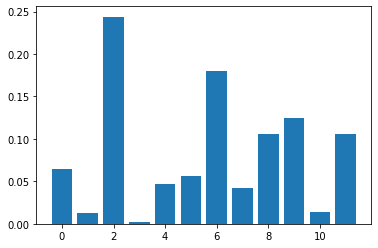

In [178]:
importance = xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Test Data

In [181]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Hackathon AnnalyticsVidya/test_mSzZ8RL.csv')
test_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [182]:
test_data = test_data.drop(['ID','Region_Code'],axis=1)

In [183]:
test_data.isna().sum()

Gender                     0
Age                        0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

In [184]:
test_data = pd.get_dummies(data=test_data, columns=['Gender','Occupation','Channel_Code','Is_Active'], drop_first = True)

In [185]:
for j,i in tqdm(enumerate(test_data['Credit_Product'])):
  if i == 'Yes':
    test_data['Credit_Product'][j] = 1
  elif i == 'No':
    test_data['Credit_Product'][j] = 0

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
105312it [00:30, 3403.15it/s]


In [186]:
# transform the dataset
test_data_imput = imputer.transform(test_data)
test_data_imput[:,2] = [1 if i >= 0.5 else 0 for i in test_data_imput[:,2]]

In [187]:
test_data_imput = pd.DataFrame(test_data_imput)
test_data_imput.columns =['Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance',
       'Gender_Male', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Channel_Code_X2', 'Channel_Code_X3',
       'Channel_Code_X4', 'Is_Active_Yes']
       
test_data_imput = np.array(test_data_imput)

In [188]:
y_pred = xgb.predict_proba(test_data_imput)[:,1]

In [189]:
y_pred[:50]

array([0.04087021, 0.18959814, 0.15533946, 0.03238248, 0.03305008,
       0.2847391 , 0.20413534, 0.07055487, 0.9970722 , 0.22814198,
       0.06558001, 0.2772749 , 0.26634732, 0.32667837, 0.0796252 ,
       0.04564856, 0.40905192, 0.06629407, 0.2187605 , 0.52297527,
       0.36461884, 0.07458144, 0.47865838, 0.55731744, 0.06796397,
       0.29574895, 0.17037791, 0.5712336 , 0.35003912, 0.6541451 ,
       0.32159477, 0.1446733 , 0.20576423, 0.14076434, 0.25195715,
       0.34570038, 0.2527344 , 0.06709312, 0.518223  , 0.16348833,
       0.06905904, 0.62463045, 0.03016891, 0.09601621, 0.41941044,
       0.05615187, 0.43453556, 0.17887032, 0.24160191, 0.49961054],
      dtype=float32)

## Sample Data

In [190]:
sample = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Hackathon AnnalyticsVidya/sample_submission_eyYijxG.csv')
sample.head()

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,0
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0


In [191]:
sample['Is_Lead'] = y_pred

In [192]:
sample.head()

,ID,Is_Lead
0,VBENBARO,0.040870
1,CCMEWNKY,0.189598
2,VK3KGA9M,0.155339
3,TT8RPZVC,0.032382
4,SHQZEYTZ,0.033050


In [193]:
sample.to_csv(r'/content/drive/MyDrive/Colab_Notebooks/Hackathon AnnalyticsVidya/submission_10.csv', index = False, header = True)